[BRANCAS] Iniciando varredura...
[BRANCAS] Encontrou 128 candidatos brutos.
[VERMELHAS] Iniciando varredura...
[VERMELHAS] Encontrou 151 candidatos brutos.
Unindo resultados...
Total Final: 40 (20 V, 20 B)


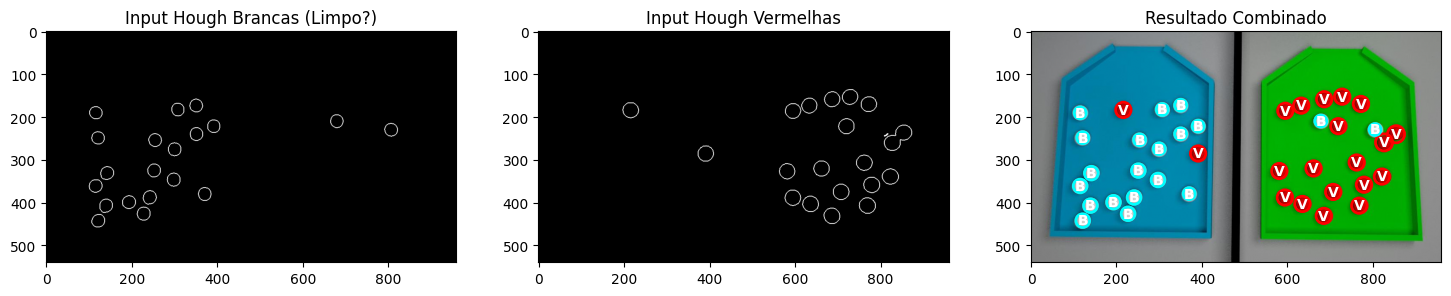

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. CONFIGURAÇÕES
# ==============================================================================
nome_do_arquivo = 'TesteIMG10.jpg'

# Raios para busca
RAIO_MIN = 8
RAIO_MAX = 55

# --- PARÂMETROS ESPECÍFICOS PARA CADA COR ---

# Para as Brancas: Limiar de corte de cor MUITO ALTO (0.65).
# Isso significa: "Só aceite coisas brilhando muito". A mesa e as linhas foscas somem.
LIMIAR_COR_BRANCA = 0.65
SENS_HOUGH_BRANCA = 0.50

# Para as Vermelhas: Limiar de corte baixo (0.10) pois R-G pode ser fraco.
LIMIAR_COR_VERMELHA = 0.10
SENS_HOUGH_VERMELHA = 0.45

# ==============================================================================
# 2. FERRAMENTAS MATEMÁTICAS
# ==============================================================================
def ler_imagem(caminho):
    try:
        img = plt.imread(caminho)
        if img.max() > 1.0: img = img / 255.0
        if img.shape[2] == 4: img = img[:, :, :3]
        return img
    except: return None

def rgb_para_cinza(img):
    # Fórmula de luminosidade
    return 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]

def extrair_vermelho_puro(img):
    # Vermelho - Verde = Isola o vermelho e apaga branco/amarelo/verde
    r = img[:,:,0]
    g = img[:,:,1]
    diff = r - g
    diff[diff < 0] = 0
    return diff

def rgb_para_hsv(img):
    # Apenas para pintar a cor certa no final
    rows, cols, ch = img.shape
    hsv_img = np.zeros((rows, cols, 3))
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    cmax = np.maximum(np.maximum(r, g), b)
    cmin = np.minimum(np.minimum(r, g), b)
    delta = cmax - cmin
    mask_delta = delta != 0
    idx_r = (cmax == r) & mask_delta
    idx_g = (cmax == g) & mask_delta
    idx_b = (cmax == b) & mask_delta
    hsv_img[idx_r, 0] = np.mod(((g[idx_r] - b[idx_r]) / delta[idx_r]), 6)
    hsv_img[idx_g, 0] = ((b[idx_g] - r[idx_g]) / delta[idx_g]) + 2
    hsv_img[idx_b, 0] = ((r[idx_b] - g[idx_b]) / delta[idx_b]) + 4
    hsv_img[:, :, 0] *= 60
    H = hsv_img[:, :, 0]
    H[H < 0] += 360
    hsv_img[:, :, 0] = H
    mask_cmax = cmax != 0
    hsv_img[mask_cmax, 1] = delta[mask_cmax] / cmax[mask_cmax]
    hsv_img[:, :, 2] = cmax
    return hsv_img

# --- Morfologia para limpar ruído ---
def criar_kernel(tamanho):
    k = np.zeros((tamanho, tamanho))
    y, x = np.ogrid[-tamanho//2 + 1:tamanho//2 + 1, -tamanho//2 + 1:tamanho//2 + 1]
    mask = x**2 + y**2 <= (tamanho//2)**2
    k[mask] = 1
    return k

def erosao(img, kernel):
    # Erosão ajuda a separar bolas coladas e remover linhas finas
    h, w = img.shape
    pad = kernel.shape[0] // 2
    padded = np.ones((h + 2*pad, w + 2*pad))
    padded[pad:-pad, pad:-pad] = img
    out = np.zeros_like(img)
    k_idx = np.where(kernel == 1)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.all(region[k_idx] > 0): out[i, j] = 1
    return out

def dilatacao(img, kernel):
    h, w = img.shape
    pad = kernel.shape[0] // 2
    padded = np.zeros((h + 2*pad, w + 2*pad))
    padded[pad:-pad, pad:-pad] = img
    out = np.zeros_like(img)
    k_idx = np.where(kernel == 1)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.any(region[k_idx] > 0): out[i, j] = 1
    return out

def borda_morfologica(img_bin):
    k = criar_kernel(3)
    return dilatacao(img_bin, k) - erosao(img_bin, k)

# ==============================================================================
# 3. HOUGH
# ==============================================================================
def executar_hough(img_borda, r_min, r_max, limiar, nome_debug):
    rows, cols = img_borda.shape
    y_idxs, x_idxs = np.where(img_borda > 0)
    candidatos = []

    print(f"[{nome_debug}] Iniciando varredura...")

    thetas = np.deg2rad(np.arange(0, 360, 10))
    cos_t, sin_t = np.cos(thetas), np.sin(thetas)
    total_votos = len(thetas)

    for r in range(r_min, r_max + 1, 2):
        acumulador = np.zeros((rows, cols))
        for i in range(len(y_idxs)):
            y, x = y_idxs[i], x_idxs[i]
            a = np.round(x - r * cos_t).astype(int)
            b = np.round(y - r * sin_t).astype(int)
            valid = (a >= 0) & (a < cols) & (b >= 0) & (b < rows)
            np.add.at(acumulador, (b[valid], a[valid]), 1)

        acumulador_norm = acumulador / total_votos
        picos = np.where(acumulador_norm > limiar)
        for py, px in zip(picos[0], picos[1]):
            candidatos.append((px, py, r, acumulador_norm[py, px]))

    print(f"[{nome_debug}] Encontrou {len(candidatos)} candidatos brutos.")
    return candidatos

# ==============================================================================
# 4. FUSÃO INTELIGENTE (MERGE)
# ==============================================================================
def unir_listas(lista_verm, lista_bran, shape):
    # Adiciona rótulos para sabermos a origem
    todos = []
    for c in lista_verm: todos.append(c + ("V",))
    for c in lista_bran: todos.append(c + ("B",))

    # 1. ORDENAÇÃO POR RAIO (Do maior para o menor)
    # Isso resolve o problema de detectar "microbolas" dentro das grandes
    todos.sort(key=lambda x: x[2], reverse=True)

    finais = []
    rows, cols, _ = shape

    for novo in todos:
        nx, ny, nr, nscore, label = novo

        # Filtro de borda da imagem
        margem = 10
        if nx < margem or nx > cols-margem or ny < margem or ny > rows-margem:
            continue

        conflito = False
        for aceito in finais:
            ax, ay, ar, ascore, alabel = aceito
            dist = np.sqrt((nx - ax)**2 + (ny - ay)**2)

            # Se o novo círculo está DENTRO de um maior já aceito
            if dist < ar * 0.9:
                conflito = True # É ruído interno
                break

            # Se são do mesmo tamanho e estão no mesmo lugar (Sobreposição)
            if dist < ar and dist < nr:
                conflito = True
                break

        if not conflito:
            finais.append(novo)

    return finais

# ==============================================================================
# 5. EXECUÇÃO SEPARADA
# ==============================================================================
img_orig = ler_imagem(nome_do_arquivo)

if img_orig is not None:

    # --- PROCESSO 1: DETECTOR DE BRANCAS ---
    # Estratégia: Limiar ALTO para ignorar mesa e linhas. Só o brilho intenso passa.
    img_gray = rgb_para_cinza(img_orig)
    # Suaviza levemente para remover textura da mesa
    img_gray_suave = np.zeros_like(img_gray)
    padded = np.pad(img_gray, 1, mode='edge')
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            img_gray_suave[i,j] = np.mean(padded[i:i+3, j:j+3])

    bin_branca = (img_gray_suave > LIMIAR_COR_BRANCA).astype(int)
    # Erosão para "desgrudar" linhas finas que sobraram
    bin_branca = erosao(bin_branca, criar_kernel(3))
    bordas_branca = borda_morfologica(bin_branca)

    cands_branca = executar_hough(bordas_branca, RAIO_MIN, RAIO_MAX, SENS_HOUGH_BRANCA, "BRANCAS")

    # --- PROCESSO 2: DETECTOR DE VERMELHAS ---
    # Estratégia: R - G. Funciona bem como você relatou.
    img_vermelha = extrair_vermelho_puro(img_orig)
    bin_vermelha = (img_vermelha > LIMIAR_COR_VERMELHA).astype(int)
    bordas_vermelha = borda_morfologica(bin_vermelha)

    cands_vermelha = executar_hough(bordas_vermelha, RAIO_MIN, RAIO_MAX, SENS_HOUGH_VERMELHA, "VERMELHAS")

    # --- FUSÃO ---
    print("Unindo resultados...")
    bolas_finais = unir_listas(cands_vermelha, cands_branca, img_orig.shape)

    # --- CLASSIFICAÇÃO FINAL (Só para garantir a cor certa no plot) ---
    img_hsv = rgb_para_hsv(img_orig)
    lista_plot = []

    n_v, n_b = 0, 0

    for (cx, cy, r, score, label_origem) in bolas_finais:
        # Verifica a cor real no pixel central
        delta = int(r/2)
        y1, y2 = max(0, cy-delta), min(img_orig.shape[0], cy+delta)
        x1, x2 = max(0, cx-delta), min(img_orig.shape[1], cx+delta)
        roi = img_hsv[y1:y2, x1:x2]

        cor_plot = "yellow"
        texto = "?"

        if roi.size > 0:
            s = np.mean(roi[:,:,1])
            v = np.mean(roi[:,:,2])

            # Se for muito clara e pouco saturada = BRANCA
            if s < 0.35 and v > 0.40:
                cor_plot = "cyan"
                texto = "B"
                n_b += 1
            else:
                cor_plot = "red"
                texto = "V"
                n_v += 1

        lista_plot.append((cx, cy, r, cor_plot, texto))

    print(f"Total Final: {len(lista_plot)} ({n_v} V, {n_b} B)")

    # --- VISUALIZAÇÃO ---
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Mostra o que cada detector "viu"
    ax[0].imshow(bordas_branca, cmap='gray')
    ax[0].set_title("Input Hough Brancas (Limpo?)")

    ax[1].imshow(bordas_vermelha, cmap='gray')
    ax[1].set_title("Input Hough Vermelhas")

    ax[2].imshow(img_orig)
    ax[2].set_title("Resultado Combinado")

    for (cx, cy, r, c, t) in lista_plot:
        circ = plt.Circle((cx, cy), r, color=c, fill=False, lw=2)
        ax[2].add_patch(circ)
        ax[2].text(cx, cy, t, color='white', weight='bold', ha='center', va='center')

    plt.show()